Selected feature: cem, Metric value: 7.4397338876594254
Selected feature: age, Metric value: 6.751721753014096
Selected feature: SP, Metric value: 5.644468857262383
Selected feature: H2O, Metric value: 4.534884687632073
Selected feature: FyA, Metric value: 3.695735900802715
Selected feature: sl, Metric value: 2.9161324001478035
Selected feature: FA, Metric value: 1.9441757576863794
Selected feature: CA, Metric value: 1.0
Time taken for feature selection: 1.75 seconds
Selected features based on Vendi score: ['cem', 'age', 'SP', 'H2O', 'FyA', 'sl', 'FA', 'CA']


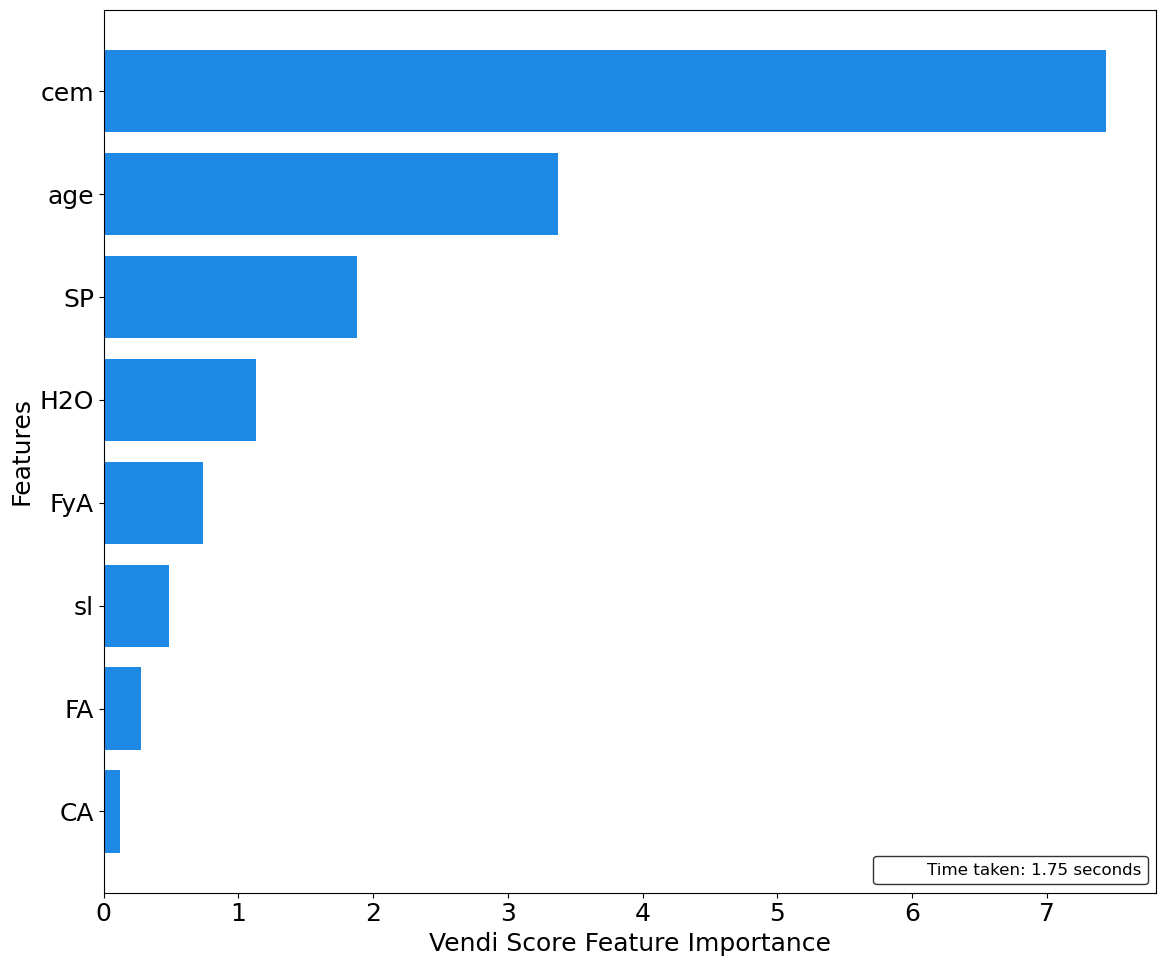

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold
from vendi_score import vendi
import matplotlib.pyplot as plt
import os
import time

# Create the Figures directory if it doesn't exist
if not os.path.exists('Figures'):
    os.makedirs('Figures')

# Load your data
X = pd.read_excel('Concrete.xlsx', sheet_name='FL', usecols='A:H', skiprows=0)
y = pd.read_excel('Concrete.xlsx', sheet_name='FL', usecols='I', skiprows=0)

# Get feature names from the columns of X
feature_names = X.columns

# Initialize selected features list and indices
selected_features = []
selected_feature_indices = []

# List to store Vendi score values
vendi_score_values = []

# Initialize prior probabilities (uniform distribution)
priors = np.ones(len(feature_names)) / len(feature_names)

# Start the timer
start_time = time.time()

# Convert y to a NumPy array
y = y.values

# Number of folds for cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

def extend_and_scale(X_test_scaled, y_test_scaled, selected_feature_indices, feature_index=None):
    """Extend and scale the feature matrix with selected features and the current feature."""
    X_ext_test = y_test_scaled
    if selected_feature_indices:
        X_ext_test = np.hstack((X_ext_test, X_test_scaled[:, selected_feature_indices]))
    if feature_index is not None:
        X_ext_test = np.hstack((X_ext_test, X_test_scaled[:, feature_index].reshape(-1, 1)))
    return X_ext_test

# Extend feature matrix and select additional features
iteration = 1
while len(selected_features) < len(feature_names):
    posteriors = np.zeros(len(feature_names))
    uncertainties = []

    # Evaluate features with cross-validation
    for feature_index, feature in enumerate(feature_names):
        if feature not in selected_features:
            # List to store Vendi scores for each fold
            vendi_scores_cv = []

            for train_index, test_index in kf.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Fit the scaler on the training set
                scaler_X = StandardScaler()
                scaler_y = StandardScaler()

                X_train_scaled = scaler_X.fit_transform(X_train)
                y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

                # Use the scaler to transform the test set
                X_test_scaled = scaler_X.transform(X_test)
                y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

                # Extend X_test by adding the current feature and previously selected features
                X_ext_test = extend_and_scale(X_test_scaled, y_test_scaled, selected_feature_indices, feature_index)

                # Calculate cosine similarity for the test set
                similarity_matrix_test = cosine_similarity(X_ext_test.T)

                # Calculate Vendi score for the extended feature matrix based on cosine similarity
                VS_test = vendi.score_K(similarity_matrix_test, normalize=True)
                vendi_scores_cv.append(VS_test)

            # Calculate uncertainty (standard deviation of Vendi scores across folds)
            uncertainty = np.std(vendi_scores_cv)
            uncertainties.append(uncertainty)

            # Calculate average Vendi score across folds
            VS_mean = np.mean(vendi_scores_cv)

            # Calculate likelihood (1/VS_mean) and account for uncertainty
            likelihood = 1 / (VS_mean + uncertainty)

            # Update posterior probability using Bayes' theorem
            posteriors[feature_index] = priors[feature_index] * likelihood

    # Normalize posteriors to sum to 1
    posteriors /= posteriors.sum()

    # Select the feature with the highest posterior probability
    best_feature_index = np.argmax(posteriors)
    best_feature = feature_names[best_feature_index]

    # Print the selected feature and its metric value
    print(f"Selected feature: {best_feature}, Metric value: {1 / posteriors[best_feature_index]}")

    # Update priors with posteriors
    priors = posteriors

    # Add the best feature to the selected features list
    selected_features.append(best_feature)
    selected_feature_indices.append(best_feature_index)
    vendi_score_values.append((1 / posteriors[best_feature_index]) / iteration)

    iteration += 1

# End the timer
end_time = time.time()
time_taken = end_time - start_time
print("Time taken for feature selection: {:.2f} seconds".format(time_taken))

print("Selected features based on Vendi score:", selected_features)

# Use the selected features at each step along with its 1/posterior for final plot
features_and_scores = list(zip(selected_features, vendi_score_values))

# Sort the features_and_scores by Vendi score values in descending order
features_and_scores_sorted = sorted(features_and_scores, key=lambda x: x[1], reverse=True)
selected_features_sorted, vendi_score_values_sorted = zip(*features_and_scores_sorted)

# Increase the font size
plt.rcParams.update({'font.size': 18})

# Plot permutation feature importance
plt.figure(figsize=(12, 10))

# Create the horizontal bar plot without a label
shap_default_blue = '#1E88E5'  
plt.barh(
    range(len(vendi_score_values_sorted), 0, -1),
    vendi_score_values_sorted,
    alpha=1.0,
    color=shap_default_blue
)

plt.ylabel('Features')
plt.yticks(range(len(vendi_score_values_sorted), 0, -1), selected_features_sorted, rotation=0)
plt.xlabel('Vendi Score Feature Importance')
plt.grid(False)

# Create a custom legend handle for the time taken
import matplotlib.patches as mpatches
time_patch = mpatches.Patch(color='none', label=f"Time taken: {time_taken:.2f} seconds")

# Add the custom legend and put it in a box
plt.legend(
    handles=[time_patch],
    loc='lower right',
    prop={'size': 12},
    fancybox=True,  # Rounded box
    framealpha=0.8,  # Transparency
    edgecolor='black'  # Box edge color
)

plt.tight_layout()

# Save the figure
plt.savefig('Figures/Boston_VS.pdf')

plt.show()